# 量化策略回测框架 (单向持仓版本)

## 核心逻辑:
1. **资金管理**: 初始资金分成10份，每份独立使用
2. **单向持仓**: 在任何时刻只持有一个方向(多头或空头)的头寸
3. **信号处理**:
    - 同向信号: 增加持仓份数(最多10份)
    - 反向信号: 减少持仓份数(先进先出)
4. **持仓管理**:
    - 使用平均成本法计算持仓成本
    - 每份持仓独立计算10周期持有期
5. **收益计算**:
    - 每次平仓(部分或全部)计算该次交易的收益
    - 手续费按实际交易金额计算

In [6]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from tabulate import tabulate
from colorama import Fore, Style
import pickle
from pathlib import Path

---
## 1. 日志和绘图设置

In [7]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

---
## 2. 核心回测与评估函数

In [8]:
def run_backtest_unidirectional(prices, signals, initial_capital=100000, commission_rate=0.0002, holding_period=10):
    """
    基于单向持仓的回测实现
    """
    logging.info(f"🤔 开始执行单向持仓回测 (持仓周期: {holding_period}, 资金分成10份)...")
    
    # 计算每份资金大小
    unit_capital = initial_capital / 10
    
    # --- 数据结构初始化 ---
    positions = []  # 存储所有活跃持仓的列表
    completed_trades = []  # 存储已完成交易的列表
    
    # 持仓状态变量
    current_direction = 0  # 当前持仓方向 (0: 无持仓, 1: 多头, -1: 空头)
    avg_cost = 0.0  # 当前平均持仓成本
    position_count = 0  # 当前持仓份数
    
    # 信号在T-1产生，在T生效
    trade_triggers = signals.shift(1).fillna(0)
    
    # --- 时间驱动的事件循环 ---
    for i in range(len(prices)):
        current_time = prices.index[i]
        current_price = prices.iloc[i]
        
        # --- 1. 处理到期平仓 ---
        expired_positions = []
        positions_to_keep = []
        
        for pos in positions:
            # 计算持仓时间 (按bar数量)
            holding_bars = i - prices.index.get_loc(pos['entry_time'])
            
            if holding_bars >= holding_period:
                # 持仓到期
                expired_positions.append(pos)
            else:
                positions_to_keep.append(pos)
        
        # 处理所有到期持仓
        for pos in expired_positions:
            # 计算该份持仓的收益
            direction = pos['direction']
            entry_price = pos['entry_price']
            exit_price = current_price
            
            # 计算收益率 (考虑手续费)
            price_ratio = exit_price / entry_price
            net_return = direction * (price_ratio - 1) - commission_rate * (1 + price_ratio)
            
            # 记录交易
            completed_trades.append({
                'entry_time': pos['entry_time'],
                'exit_time': current_time,
                'direction': direction,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'net_return': net_return,
                'type': 'Expired',
                'position_size': unit_capital
            })
            
            # 更新持仓状态
            position_count -= 1
        
        positions = positions_to_keep
        
        # 如果所有持仓都已平仓，重置持仓状态
        if position_count == 0:
            current_direction = 0
            avg_cost = 0.0
        
        # --- 2. 处理新信号 ---
        new_signal = trade_triggers.iloc[i]
        
        if new_signal != 0:
            if current_direction == 0:
                # 情况1: 无持仓 -> 开新仓
                positions.append({
                    'entry_time': current_time,
                    'entry_price': current_price,
                    'direction': new_signal
                })
                current_direction = new_signal
                position_count = 1
                avg_cost = current_price
                
            elif current_direction == new_signal:
                # 情况2: 同向信号 -> 加仓 (最多10份)
                if position_count < 10:
                    positions.append({
                        'entry_time': current_time,
                        'entry_price': current_price,
                        'direction': new_signal
                    })
                    position_count += 1
                    # 更新平均成本
                    total_value = avg_cost * (position_count - 1) + current_price
                    avg_cost = total_value / position_count
                    
            else:
                # 情况3: 反向信号 -> 减仓 (先进先出)
                if positions:
                    # 移除最早的持仓 (先进先出)
                    oldest_position = positions.pop(0)
                    
                    # 计算该份持仓的收益
                    direction = oldest_position['direction']
                    entry_price = oldest_position['entry_price']
                    exit_price = current_price
                    
                    # 计算收益率 (考虑手续费)
                    price_ratio = exit_price / entry_price
                    net_return = direction * (price_ratio - 1) - commission_rate * (1 + price_ratio)
                    
                    # 记录交易
                    completed_trades.append({
                        'entry_time': oldest_position['entry_time'],
                        'exit_time': current_time,
                        'direction': direction,
                        'entry_price': entry_price,
                        'exit_price': exit_price,
                        'net_return': net_return,
                        'type': 'Signal Offset',
                        'position_size': unit_capital
                    })
                    
                    # 更新持仓状态
                    position_count -= 1
                    
                    # 如果平仓后仍有持仓，更新平均成本
                    if position_count > 0:
                        total_value = sum(p['entry_price'] for p in positions)
                        avg_cost = total_value / position_count
                    else:
                        current_direction = 0
                        avg_cost = 0.0
    
    # --- 3. 回测结束，强制平掉所有剩余的活跃仓位 ---
    final_time = prices.index[-1]
    final_price = prices.iloc[-1]
    
    for pos in positions:
        # 计算该份持仓的收益
        direction = pos['direction']
        entry_price = pos['entry_price']
        exit_price = final_price
        
        # 计算收益率 (考虑手续费)
        price_ratio = exit_price / entry_price
        net_return = direction * (price_ratio - 1) - commission_rate * (1 + price_ratio)
        
        # 记录交易
        completed_trades.append({
            'entry_time': pos['entry_time'],
            'exit_time': final_time,
            'direction': direction,
            'entry_price': entry_price,
            'exit_price': exit_price,
            'net_return': net_return,
            'type': 'End of Backtest',
            'position_size': unit_capital
        })
    
    logging.info(f"回测完成。共结算 {len(completed_trades)} 笔交易。")
    if not completed_trades:
        logging.warning("未能生成任何交易。")
        return pd.DataFrame(), pd.DataFrame()
    
    # --- 4. 构建结果 ---
    trades_df = pd.DataFrame(completed_trades)
    
    # 计算每笔交易的绝对收益 (基于单位资金)
    trades_df['absolute_pnl'] = trades_df['net_return'] * unit_capital
    
    # 计算每日实现的净收益流
    pnl_by_exit_time = trades_df.groupby('exit_time')['absolute_pnl'].sum()
    daily_net_pnl = pnl_by_exit_time.reindex(prices.index).fillna(0)
    
    # 计算累计收益 (单利)
    cumulative_pnl = daily_net_pnl.cumsum()
    equity_curve = initial_capital + cumulative_pnl
    
    # 整合最终结果
    backtest_results = pd.DataFrame(index=prices.index)
    backtest_results['close'] = prices
    backtest_results['signal'] = signals
    backtest_results['daily_pnl'] = daily_net_pnl
    backtest_results['equity_curve'] = equity_curve
    
    return backtest_results, trades_df

In [9]:
def evaluate_performance(backtest_results, trades_df, initial_capital):
    """
    评估策略表现 (适配单向持仓策略)
    """
    logging.info("开始评估策略表现...")

    if backtest_results.empty or trades_df.empty:
        logging.error("回测结果为空，无法进行评估。")
        return

    # --- 提取数据 ---
    equity_curve = backtest_results['equity_curve']
    daily_pnl = backtest_results['daily_pnl']
    
    # --- 核心指标计算 ---
    # 总收益
    total_return = (equity_curve.iloc[-1] - initial_capital) / initial_capital
    
    # 年化收益
    total_days = (equity_curve.index[-1] - equity_curve.index[0]).days
    duration_years = total_days / 365.25 if total_days > 0 else 1
    annualized_return = total_return / duration_years if duration_years > 0 else 0
    
    # 年化波动率
    daily_returns = daily_pnl / initial_capital
    monthly_returns = daily_returns.resample('M').sum()
    annualized_volatility = monthly_returns.std() * np.sqrt(12) if not monthly_returns.empty else 0
    
    # 最大回撤
    peak = equity_curve.expanding(min_periods=1).max()
    drawdown = (peak - equity_curve) / peak
    max_drawdown = drawdown.max()
    
    # 夏普比率 (基于年化)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility > 0 else 0
    
    # 卡玛比率
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else 0
    
    # 交易统计
    total_trades = len(trades_df)
    winning_trades = trades_df[trades_df['net_return'] > 0]
    losing_trades = trades_df[trades_df['net_return'] <= 0]
    win_rate = len(winning_trades) / total_trades if total_trades > 0 else 0
    
    # 盈亏比
    avg_win = winning_trades['net_return'].mean() if not winning_trades.empty else 0
    avg_loss = abs(losing_trades['net_return'].mean()) if not losing_trades.empty else 0
    profit_loss_ratio = avg_win / avg_loss if avg_loss > 0 else np.inf
    
    # 期望收益
    expectancy = (win_rate * avg_win) - ((1 - win_rate) * avg_loss)

    # --- 打印报告 ---
    print("\n" + "="*80)
    print(Fore.CYAN + Style.BRIGHT + " " * 25 + "策略性能评估报告" + " " * 25 + Style.RESET_ALL)
    print("="*80)
    
    detail_headers = ["指标名称", "值"]
    detail_table = [
        ["回测模型", "单向持仓 (资金分10份)"],
        ["总收益率", f"{total_return:.2%}"],
        ["年化收益率", f"{annualized_return:.2%}"],
        ["年化波动率", f"{annualized_volatility:.2%}"],
        ["夏普比率", f"{sharpe_ratio:.4f}"],
        ["最大回撤", f"{max_drawdown:.2%}"],
        ["卡玛比率", f"{calmar_ratio:.4f}"],
        ["总交易笔数", f"{total_trades}"],
        ["胜率", f"{win_rate:.2%}"],
        ["盈亏比", f"{profit_loss_ratio:.4f}"],
        ["期望收益", f"{expectancy:.6f}"],
        ["最终资金", f"${equity_curve.iloc[-1]:,.2f}"]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))

    # --- 交易类型分析 ---
    print("\n" + Fore.CYAN + Style.BRIGHT + "--- 交易类型分析 ---" + Style.RESET_ALL)
    trade_type_counts = trades_df['type'].value_counts().reset_index()
    trade_type_counts.columns = ['平仓类型', '数量']
    trade_type_counts['占比'] = (trade_type_counts['数量'] / total_trades * 100).apply(lambda x: f"{x:.2f}%")
    print(tabulate(trade_type_counts, headers="keys", tablefmt="grid", stralign="center", showindex=False))

    # --- 绘制权益曲线图 ---
    fig, ax = plt.subplots(figsize=(20, 10))
    equity_curve.plot(label='策略权益曲线', lw=2, color='royalblue', ax=ax)
    ax.set_title('Strategy Curve', fontsize=16)
    ax.set_ylabel('Equity Value', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    logging.info("策略评估完成")

---
## 3. 主程序执行

2025-07-25 00:23:35,446 - INFO - 正在从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-25 00:23:35,455 - INFO - 数据加载成功。
2025-07-25 00:23:35,455 - INFO - 🤔 开始执行单向持仓回测 (持仓周期: 10, 资金分成10份)...
2025-07-25 00:23:38,086 - INFO - 回测完成。共结算 25526 笔交易。
2025-07-25 00:23:38,126 - INFO - 已完成交易详情 (前5笔):
2025-07-25 00:23:38,132 - INFO - 开始评估策略表现...


           entry_time           exit_time  direction  entry_price  exit_price  \
0 2021-09-27 06:30:00 2021-09-27 09:00:00        1.0     44037.70    43951.58   
1 2021-09-27 06:45:00 2021-09-27 09:15:00        1.0     43722.06    43968.01   
2 2021-09-27 07:00:00 2021-09-27 09:30:00        1.0     43790.32    43593.57   
3 2021-09-27 07:15:00 2021-09-27 09:45:00        1.0     43759.99    43540.56   
4 2021-09-27 07:45:00 2021-09-27 10:15:00        1.0     43665.96    43794.64   

   net_return     type  position_size  absolute_pnl  
0   -0.002355  Expired        10000.0    -23.552060  
1    0.005224  Expired        10000.0     52.241817  
2   -0.004892  Expired        10000.0    -48.921035  
3   -0.005413  Expired        10000.0    -54.133950  
4    0.002546  Expired        10000.0     25.463285  

                         与理论基准的相关性检验                         
策略累计净收益与理论基准的相关系数为: -0.47722168
⚠️ 策略与理论基准相关性不高：显著改变了策略。


                         策略性能评估报告                         
+-------

/tmp/ipykernel_3063520/1670658698.py:91: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3063520/1670658698.py:91: UserWarning: Glyph 30053 (\N{CJK UNIFIED IDEOGRAPH-7565}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3063520/1670658698.py:91: UserWarning: Glyph 26435 (\N{CJK UNIFIED IDEOGRAPH-6743}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3063520/1670658698.py:91: UserWarning: Glyph 30410 (\N{CJK UNIFIED IDEOGRAPH-76CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3063520/1670658698.py:91: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_3063520/1670658698.py:91: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/wj/miniconda3/envs/cta_v1/lib/python3.11/site-packages/IPython/core/py

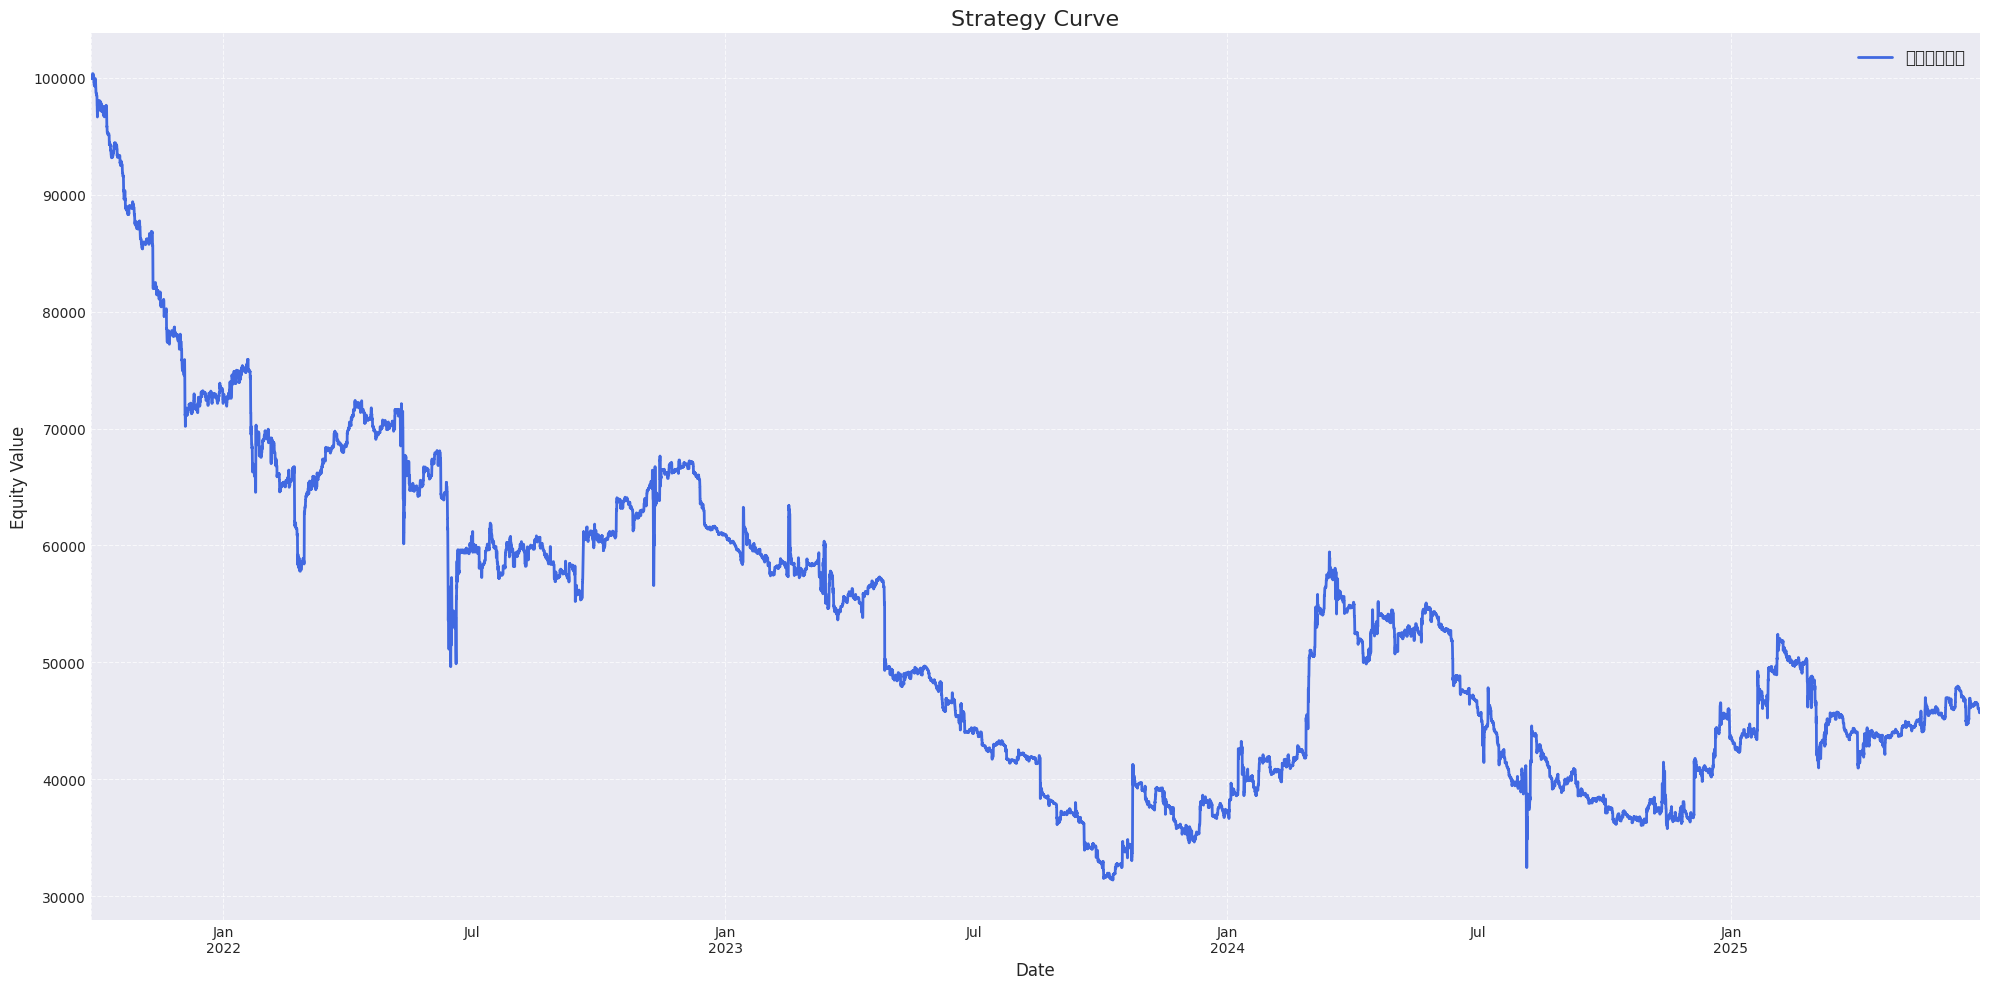

2025-07-25 00:23:39,959 - INFO - 策略评估完成


In [10]:
if __name__ == '__main__':
    # --- 1. 参数配置 ---
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    COMMISSION_RATE = 0.0002
    INITIAL_CAPITAL = 100000
    HOLDING_PERIOD = 10
    
    # --- 2. 数据加载 ---
    logging.info(f"正在从 {FILE_PATH} 加载数据...")
    try:
        file_path = Path(FILE_PATH)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        data.index = pd.to_datetime(data.index)
        data = data.rename_axis('open_time')
        logging.info("数据加载成功。")
    except Exception as e:
        logging.error(f"加载数据时发生错误: {e}")
        data = None

    # --- 3. 执行回测 (使用单向持仓版本) ---
    if data is not None:
        backtest_results, trades_df = run_backtest_unidirectional(
            prices=data['close'],
            signals=data['signal'],
            initial_capital=INITIAL_CAPITAL,
            commission_rate=COMMISSION_RATE,
            holding_period=HOLDING_PERIOD
        )
        
        logging.info("已完成交易详情 (前5笔):")
        print(trades_df.head())

        # --- 4. 与理论基准的相关性检验 ---
        print("\n" + "="*80)
        print(Fore.YELLOW + Style.BRIGHT + " " * 25 + "与理论基准的相关性检验" + " " * 25 + Style.RESET_ALL)
        print("="*80)

        # 计算理论基准收益
        theoretical_forward_returns = (data['close'].shift(-HOLDING_PERIOD) / data['close']) - 1
        theoretical_per_trade_returns = data['signal'].shift(1) * theoretical_forward_returns
        theoretical_cumulative_returns = theoretical_per_trade_returns.cumsum().fillna(0)

        # 获取策略的累计净收益
        strategy_cumulative_returns = (backtest_results['equity_curve'] - INITIAL_CAPITAL) / INITIAL_CAPITAL

        # 计算相关性
        correlation = strategy_cumulative_returns.corr(theoretical_cumulative_returns)

        print(f"策略累计净收益与理论基准的相关系数为: {Fore.CYAN}{correlation:.8f}{Style.RESET_ALL}")
        
        if correlation > 0.8:
            print(Fore.GREEN + "✅ 策略与理论基准高度相关：整体趋势一致。" + Style.RESET_ALL)
        else:
            print(Fore.YELLOW + "⚠️ 策略与理论基准相关性不高：显著改变了策略。" + Style.RESET_ALL)
        print("="*80 + "\n")

        # --- 5. 性能评估 ---
        evaluate_performance(
            backtest_results, 
            trades_df,
            INITIAL_CAPITAL
        )
    else:
        logging.warning("由于数据加载失败，回测和评估步骤已跳过。")